<a href="https://colab.research.google.com/github/caiovitfernandes/Detec-o-de-Cataratas-utilizando-CNN-s/blob/main/PoC_TCC_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prova de conceito (PoC) para o TCC de Sistemas de Informação: Análise comparativa de arquiteturas de redes neurais para detecção de cataratas em imagens clínicas, com ênfase na redução de falsos negativos
* **Objetivo:** Esta prova de conceito tem por objetivo validar a complexidade técnica de se implementar uma rede neural convolucional para realização da tarefa de detecção de cataratas através de transfer learning. Servirá para análise do aluno acerca da viabilidade da execução da parte prática do TCC no tempo disponível para tal. Além disso, a PoC tem por objetivo criar uma baseline (ou um código base) para implementação futura no TCC.
* **Aluno:** Caio Vitor Souza Fernandes
* **Semestre/Ano:** 2/2025
* **Versão:** 2.0

## Configuração do ambiente de execução

### Instalação do Kaggle

In [ ]:
!pip install Kaggle

### Importação das bibliotecas necessárias

In [ ]:
# Ambiente de execução
import os       # para trabalhar com o sistema operacional
import shutil   # para mover e copiar arquivos e pastas
import random   # para gerar números aleatórios na divisão de dados
from google.colab import files # para trabalhar com arquivos no google.colab

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Métricas de ML
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Representação gráfica
import matplotlib.pyplot as plt # para plotar gráficos
import seaborn as sns

### Verificando a GPU que está disponível

In [ ]:
print(f"GPU disponível no ambiente: {tf.config.list_physical_devices('GPU')}")

GPU disponível no ambiente: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Setando a seed a ser usada no random para garantir a reprodutibilidade

In [ ]:
random.seed(100)

## Download e acomodação do dataset

### Subindo a chave de API do Kaggle



In [ ]:
files.upload() # Abre uma caixa para que eu suba o arquivo
!mkdir -p ~/.kaggle # Cria uma pasta ~/.kaggle
!cp kaggle.json ~/.kaggle/ # Move o arquivo kaggle.json para a pasta ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json # Define as permissões do arquivo kaggle.json para 600 (isso quer dizer que só eu posso ler e escrever no arquivo)

Saving kaggle.json to kaggle (1).json


### Fazendo o download do dataset

In [ ]:
!kaggle datasets download -d nandanp6/cataract-image-dataset # Baixa o dataset
!unzip cataract-image-dataset.zip # Descompacta o arquivo baixado

Dataset URL: https://www.kaggle.com/datasets/nandanp6/cataract-image-dataset
License(s): copyright-authors
cataract-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cataract-image-dataset.zip
replace processed_images/test/cataract/image_246.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: processed_images/test/cataract/image_246.png  
  inflating: processed_images/test/cataract/image_247.png  
  inflating: processed_images/test/cataract/image_248.png  
  inflating: processed_images/test/cataract/image_249.png  
  inflating: processed_images/test/cataract/image_250.png  
  inflating: processed_images/test/cataract/image_251.png  
  inflating: processed_images/test/cataract/image_252.png  
  inflating: processed_images/test/cataract/image_253.png  
  inflating: processed_images/test/cataract/image_254.png  
  inflating: processed_images/test/cataract/image_255.png  
  inflating: processed_images/test/cataract/image_25

### Olhando a estrutura do que foi baixado

In [ ]:
print("Estrutura de pastas do que foi baixado:\n")
!ls -la processed_images

train_normal = 'processed_images/train/normal'
train_cataract = 'processed_images/train/cataract'
test_normal = 'processed_images/test/normal'
test_cataract = 'processed_images/test/cataract'

print('_' * 50)
print('\n'
'Imagens na pasta de treino:\n'
f'- Normal: {len(os.listdir(train_normal))} imagens\n'
f'- Cataratas: {len(os.listdir(train_cataract))} imagens\n'
'\nImagens na pasta de teste:\n'
f'- Normal: {len(os.listdir(test_normal))} imagens\n'
f'- Cataratas: {len(os.listdir(test_cataract))} imagens')

Estrutura de pastas do que foi baixado:

total 20
drwxr-xr-x 5 root root 4096 Aug 27 01:40 .
drwxr-xr-x 1 root root 4096 Aug 27 01:49 ..
drwxr-xr-x 4 root root 4096 Aug 27 01:40 test
drwxr-xr-x 4 root root 4096 Aug 27 01:40 train
drwxr-xr-x 4 root root 4096 Aug 27 01:40 validation
__________________________________________________

Imagens na pasta de treino:
- Normal: 246 imagens
- Cataratas: 245 imagens

Imagens na pasta de teste:
- Normal: 60 imagens
- Cataratas: 61 imagens


## Preparação dos dados

### Parâmetros

In [ ]:
SPLIT_PERCENTAGE = 0.2 # Percentual dos dados de treino que serão usados em validação
IMG_SIZE = (224, 224) # Tamanho da imagem de entrada em pixels de largura x comprimento
BATCH_SIZE = 32 # Quantidade de imagens a serem processadas por vez
GENERATOR_SEED = 42 # Seed para o gerador de dados para reprodutibilidade

### Funções

#### Divisão de dados em duas pastas em um percentual definido

In [ ]:
def split_data(source_folder, destination_folder, split_percentage=SPLIT_PERCENTAGE):
  # Listar as imagens na pasta
  all_files = os.listdir(source_folder)

  # Embaralhar as imagens
  random.shuffle(all_files)

  # Obtém a quantidade de imagens que representa o percentual passado nos parâmetros
  destination_count = int(len(all_files) * split_percentage)

  print(f"Total de imagens em {source_folder}: {len(all_files)}")
  print("_" * 50)
  print('\n')
  print(f"Quantidade a ir para {destination_folder}: {destination_count}")
  print("_" * 50)
  print('\n')
  print(f"Restarão em {source_folder}: {len(all_files) - destination_count}")
  print("_" * 50)
  print('\n')

  # Movendo as imagens para o destino
  for i in range(destination_count):
    file_name = all_files[i]
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)
    shutil.move(source_path, destination_path)

  print(f"{destination_count} imagens movidas para {destination_folder}")

### Criando o conjunto de validação a partir dos dados de treino

In [ ]:
os.makedirs('processed_images/validation/normal', exist_ok=True) # Cria a pasta de normal para validação
os.makedirs('processed_images/validation/cataract', exist_ok=True) # Cria a pastas de cataratas para validação

split_data(train_cataract, 'processed_images/validation/cataract') # Move as imagens de cataratas para a pasta de validação
split_data(train_normal, 'processed_images/validation/normal') # Move as imagens normais para a pasta de validação

# Verificando a nova divisão
validation_normal = 'processed_images/validation/normal'
validation_cataract = 'processed_images/validation/cataract'

print("Nova distribuição:")
print('\n')
print("Treino:")
print(f"Normal: {len(os.listdir(train_normal))}")
print(f"Catarata: {len(os.listdir(train_cataract))}")
print("_" * 50)
print('\n')

print("Validação:")
print(f"Normal: {len(os.listdir(validation_normal))}")
print(f"Catarata: {len(os.listdir(validation_cataract))}")
print("_" * 50)
print('\n')

print("Teste:")
print(f"Normal: {len(os.listdir(test_normal))}")
print(f"Catarata: {len(os.listdir(test_cataract))}")

Total de imagens em processed_images/train/cataract: 245
__________________________________________________


Quantidade a ir para processed_images/validation/cataract: 49
__________________________________________________


Restarão em processed_images/train/cataract: 196
__________________________________________________


49 imagens movidas para processed_images/validation/cataract
Total de imagens em processed_images/train/normal: 246
__________________________________________________


Quantidade a ir para processed_images/validation/normal: 49
__________________________________________________


Restarão em processed_images/train/normal: 197
__________________________________________________


49 imagens movidas para processed_images/validation/normal
Nova distribuição:


Treino:
Normal: 197
Catarata: 196
__________________________________________________


Validação:
Normal: 49
Catarata: 49
__________________________________________________


Teste:
Normal: 60
Catarata: 61


### Criando os geradores de dados

In [ ]:
# Gerador de dados de treino
train_datagen = ImageDataGenerator(
    rescale = 1./255, # normaliza os valores dos pixels de 0-255 para 0-1
    rotation_range = 20, # rotação aleatória em até 20 graus por imagem
    width_shift_range = 0.1, # move as imagens horizontalmente em até 10%
    height_shift_range = 0.1, # faz o mesmo, porém verticalmente
    horizontal_flip = True, # inverte horizontalmente com probabilidade de 50%
    zoom_range = 0.1, # zoom aleatório em até 20%
    fill_mode= 'nearest' # Preenche os pixels vazios gerados nas rotações e reenquadramentos usando o pixel mais próximo (uma cópia dele)
)

train_generator = train_datagen.flow_from_directory(
    'processed_images/train',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary', # duas classes (cataratas -> 0 e normal -> 1)
    seed = GENERATOR_SEED,
    shuffle = True
)

# Gerador de dados de validação
validation_datagen = ImageDataGenerator(
    rescale = 1./255 # apenas reescalando os píxel de 0-1
)

validation_generator = validation_datagen.flow_from_directory(
  'processed_images/validation',
  target_size = IMG_SIZE,
  batch_size = BATCH_SIZE,
  class_mode = 'binary',
  seed = GENERATOR_SEED,
  shuffle = False # Não há necessidade de embaralhar as imagens na validação
)

# Gerador de dados de teste
test_datagen = ImageDataGenerator(
    rescale = 1./255 # apenas reescalando os píxel de 0-1
)

test_generator = test_datagen.flow_from_directory(
    'processed_images/test',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    seed = GENERATOR_SEED,
    shuffle = False # não se deve embaralhar as imagens de teste
)

Found 393 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


### Verificando se as classes encontradas pelos geradores estão corretas

In [ ]:
print("Classes encontradas:", train_generator.class_indices)
print(f"Imagens de treino encontradas pelo gerador: {train_generator.samples}")
print(f"Imagens de validação encontradas pelo gerador: {validation_generator.samples}")
print(f"Imagens de teste encontradas pelo gerador: {test_generator.samples}")

Classes encontradas: {'cataract': 0, 'normal': 1}
Imagens de treino encontradas pelo gerador: 393
Imagens de validação encontradas pelo gerador: 98
Imagens de teste encontradas pelo gerador: 121


## Obtenção do modelo pré-treinado

### Parâmetros

In [ ]:
WEIGHTS = 'imagenet' # pesos pré-treinados a serem utilizados
INPUT_SHAPE = (224, 224, 3) # formato das imagens de entrada para o modelo

### Importando o modelo base

In [ ]:
base_model = VGG16(
    weights = WEIGHTS, # carrega os pesos pré-treinados
    include_top = False, # remove a última camada (a que faz a classificação)
    input_shape = INPUT_SHAPE # define o formato das imagens de entrada em 224x224 além do RGB (o 3 final)
)

base_model.trainable = False # Congela as camadas do modelo que importamos do ImageNet (para não treinarmos elas)

print(f"{base_model.name} carregado! Camadas congeladas: {len(base_model.layers)}")

vgg16 carregado! Camadas congeladas: 19


### Conhecendo a arquitetura do modelo base

In [ ]:
print("Arquitetura do modelo base:")
base_model.summary()

Arquitetura do modelo base:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Personalizando o modelo

### Parâmetros

In [ ]:
BASE_LEARNING_RATE = 0.0001 # Taxa de aprendizado inicial. Sugestão do professor, deixar em 10e-4

# Métricas de validação a serem salvas. A sugestão do professor de medir o f1_score foi implementada posteriormente com scikit_learn pois é um cálculo partindo do recall e da precisão
METRICS = ['accuracy', 'precision', 'recall']

### Escolhendo as camadas personalizadas

In [ ]:
inputs = keras.Input(shape = INPUT_SHAPE)
aux = base_model(inputs, training = False) # Passando o modelo para uma variável auxiliar onde adicionaremos as camadas personalizadas

# Camadas
aux = GlobalAveragePooling2D()(aux) # Converte as features (características) 2D em 1D (para criar um vetor no lugar da matriz)
aux = Dropout(0.3)(aux) # Removendo 50% dos neurônios para evitar o overfitting. Os neurônios removidos são das camadas novas e são removidos só no treino. No teste e validação eles participam. Dropout reduzido para 0.3 como sugestão do professor
aux = Dense(128, activation = 'relu')(aux) # Camada densa com 128 neurônios e função Relu de ativação
aux = Dropout(0.3)(aux) # Outro dropout. Dropout reduzido para 0.15 após teste de limite de dropout sem overffiting. Sugestão do professor
outputs = Dense(1, activation = 'sigmoid')(aux) # Camada de saída com apenas 1 neurônio e função de ativação sigmoid para sair de 0-1 (probabilidade de catarata)

### Criando o modelo personalizado com as camadas novas

In [ ]:
model = Model(inputs, outputs)
print("Modelo criado com sucesso!")

Modelo criado com sucesso!


### Compilando o modelo criado

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate= BASE_LEARNING_RATE),
    loss = 'binary_crossentropy',
    metrics = METRICS
)

print("Modelo compilado com sucesso!")
model.summary()

Modelo compilado com sucesso!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Treinamento do modelo

### Parâmetros

In [ ]:
EARLY_STOP_PATIENCE = 20 # Número de épocas sem melhora para o early stopping
EARLY_STOP_METRIC = 'val_accuracy' # Métrica a ser monitorada para o early stopping. Avaliar a proporção entre recall e acurácia também, não só uma métrica única
EARLY_STOP_MODE = 'max' # Diz o que espero da métrica (maximizar ou minimizar)
MAX_EPOCHS = 90 # Número máximo de épocas para o treinamento

### Escolhendo e configurando os callbacks

In [ ]:
early_stopping = EarlyStopping( # Para quando o treinamento não melhora mais o modelo
    monitor = EARLY_STOP_METRIC, # Monitora o recall na validação (já que é a métrica que estamos interessados)
    patience = EARLY_STOP_PATIENCE, # Ele espera até x épocas sem nenhuma melhora
    restore_best_weights = True, # Restaura os pesos do melhor modelo encontrado durante o treinamento
    mode = EARLY_STOP_MODE, # Dizendo que o que estamos olhando é para a maximização do recall
    verbose = 1 # é para mostrar a barra de progresso
)

checkpoint = ModelCheckpoint( # Salva o melhor modelo obtido no treinamento
    f'best_model_{base_model.name}.keras', # nome que ele vai usar para salvar o checkpoint
    monitor = EARLY_STOP_METRIC, # Salva quando o recall melhora (métrica que queremos maximizar)
    save_best_only = True, # Só salva quando melhora
    mode = EARLY_STOP_MODE, # Queremos maximizar o recall
    verbose = 1
)

reduce_lr = ReduceLROnPlateau( # Isso reduz o learning rate do otimizador Adam quando chegamos num platô de aprendizagem (empaca)
    monitor = 'val_loss', # Monitora a perda na validação para verificar se a perda não está mudando (tendendo a um platô)
    factor = 0.2, # Quando acontecer, ele reduz a taxa de aprendizagem em 20%
    patience = 3, # Espera 3 épocas sem melhora
    min_lr = 0.000001, # Esse é o menor learning rate aceito
    verbose = 1
)


### Treinando o modelo

In [ ]:
history = model.fit( # fit é o treinamento de fato
    train_generator, # os dados que geramos para treino
    epochs = MAX_EPOCHS, # quantidade máxima de épocas
    validation_data = validation_generator, # dados que geramos para validação
    callbacks = [early_stopping, reduce_lr, checkpoint], # callbacks que serão monitorados
    verbose = 1
)

print("Treinamento concluído!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/90
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4961 - loss: 0.7545 - precision: 0.4769 - recall: 0.3696
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to best_model_vgg16.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4963 - loss: 0.7538 - precision: 0.4785 - recall: 0.3791 - val_accuracy: 0.5714 - val_loss: 0.6116 - val_precision: 0.8889 - val_recall: 0.1633 - learning_rate: 0.0010
Epoch 2/90
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6406 - loss: 0.6192 - precision: 0.6635 - recall: 0.6584
Epoch 2: val_accuracy improved from 0.57143 to 0.81633, saving model to best_model_vgg16.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6426 - loss: 0.6179 - precision: 0.6641 - recall: 0.6588 - val_accuracy: 0.8163 - val_loss: 0.5228 - val_precision: 0.7627 - val_recall: 0.9184 - learning_rate: 0.0010
Epoch 3/90
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6895 - loss: 0.6001 - precision: 0.6676 - recall: 0.7474
Epoch 3: va

## Validação do modelo

### Funções

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize = (15, 10)) # Cria uma grade 2x2 de gráficos com as posições [0,0], [0,1]... que vou utilizar com os axes

    # Perda
    axes[0, 0].plot(history.history['loss'], label = 'Treino', color = 'blue')
    axes[0,0].plot(history.history['val_loss'], label = 'Validação', color = 'red')
    axes[0,0].set_title('Funcao de Perda')
    axes[0,0].set_xlabel('Época')
    axes[0,0].set_ylabel('Perda')
    axes[0,0].legend() # Exibe a legenda no gráfico

    # Acurácia
    axes[0, 1].plot(history.history['accuracy'], label = 'Treino', color = 'blue')
    axes[0, 1].plot(history.history['val_accuracy'], label = 'Validação', color = 'red')
    axes[0, 1].set_title('Acurácia')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Acurácia')
    axes[0,1].legend()

    # Recall (métrica principal)
    axes[1, 0].plot(history.history['recall'], label = 'Treino', color = 'blue')
    axes[1, 0].plot(history.history['val_recall'], label = 'Validação', color = 'red')
    axes[1, 0].set_title('Recall')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()

    # Precisão
    axes[1, 1].plot(history.history['precision'], label = 'Treino', color = 'blue')
    axes[1, 1].plot(history.history['val_precision'], label = 'Validação', color = 'red')
    axes[1, 1].set_title('Precisão')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Precisão')
    axes[1, 1].legend()

    plt.tight_layout() # Ajusta o layout para caber tudo na tela
    plt.show()

### Imprimindo os gráficos de validação

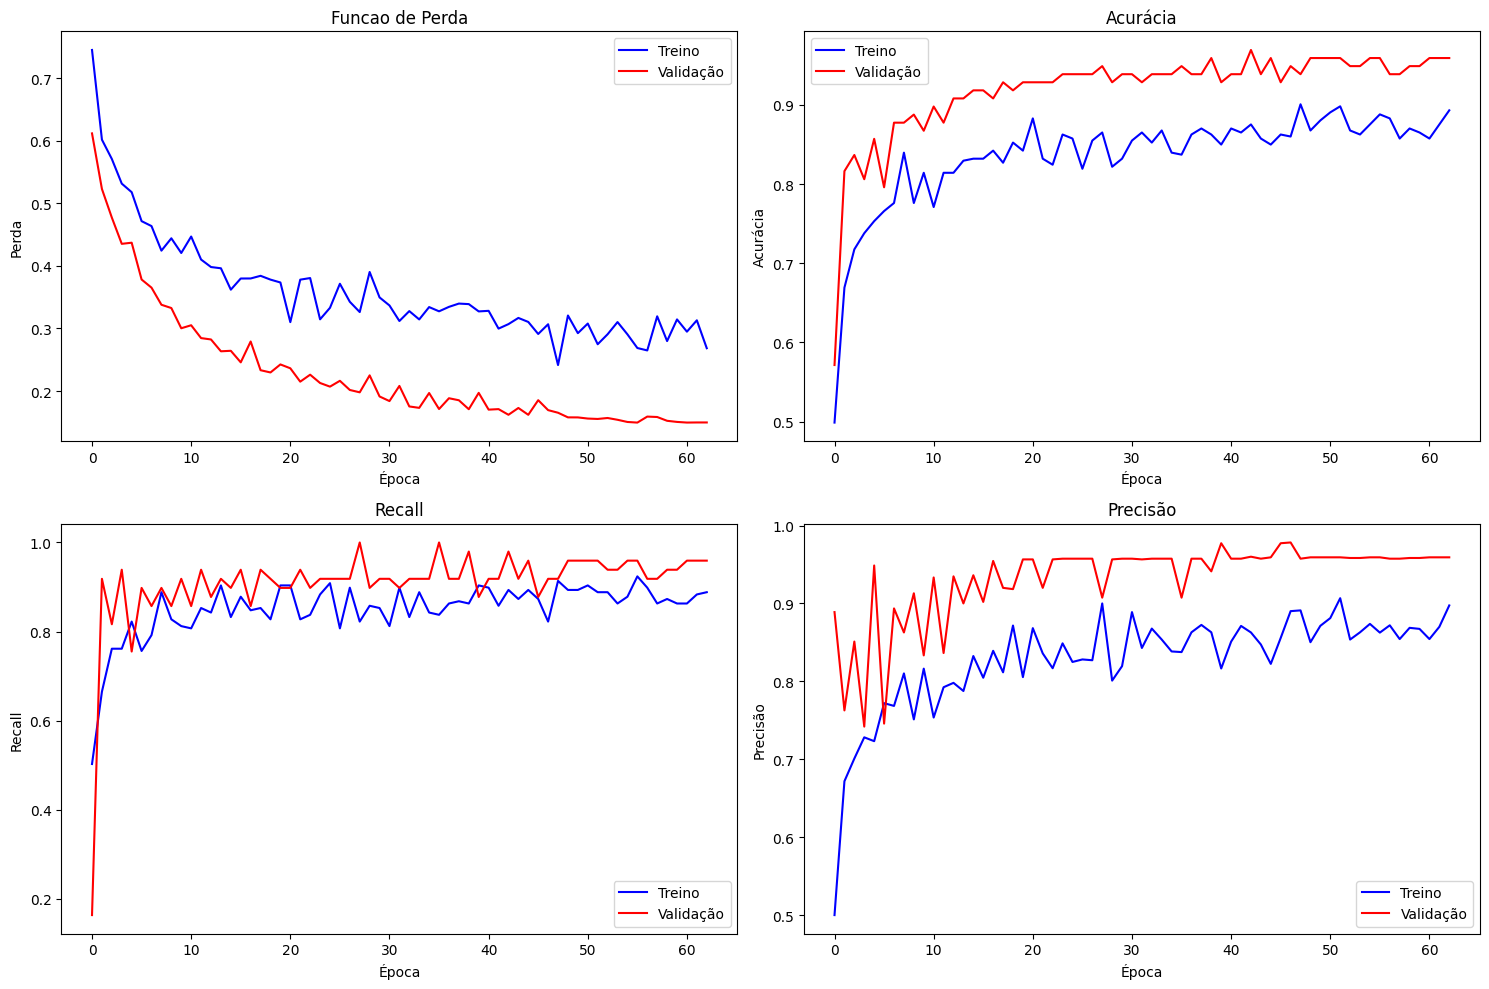

In [ ]:
plot_training_history(history)

## Teste do modelo

### Parâmetros

In [ ]:
THRESHOLD = 0.5 # Define o limite superior para que o modelo considere que é da classe 0. Ou seja, o que é <= THRESHOLD é 0 e o que é > é 1
POSITIVE_LABEL = 0 # Define qual rótulo que representa positivo. Ou seja, catarata foi rotulada com qual valor? 0 ou 1?

### Recuperando o melhor modelo salvo pelo checkpoint model

In [ ]:
print("Carregando o melhor modelo salvo...")
model.load_weights(f'best_model_{base_model.name}.keras')
print("Modelo carregado!")

Carregando o melhor modelo salvo...
Modelo carregado!


### Fazendo as predições para o conjunto de teste

In [ ]:
print("Fazendo predições no conjunto de teste...")
test_predictions = model.predict(test_generator) # usa o modelo e faz previsões nos dados gerados para teste
print(f"Predições feitas em {len(test_predictions)} amostras.")

Fazendo predições no conjunto de teste...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 752ms/step
Predições feitas em 121 amostras.


### Convertendo os resultados em classes binárias com o threshold

In [ ]:
test_labels = test_generator.classes # Obtém os resultados verdadeiros. Ou seja, os rótulos originais, ou resultados desejados
predicted_classes = (test_predictions > THRESHOLD).astype(int) # Converte os resultados do modelo em 0 e 1 baseado no threshold
predicted_classes = predicted_classes.reshape(-1) # Remove uma dimensão, pois o resultado do modelo é uma matriz de uma coluna e queremos um vetor

print(f"Rótulos verdadeiros: {test_labels}")
print(f"Predições: {predicted_classes}")

Rótulos verdadeiros: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
Predições: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1]


### Exibindo os resultados

#### Matriz de confusão

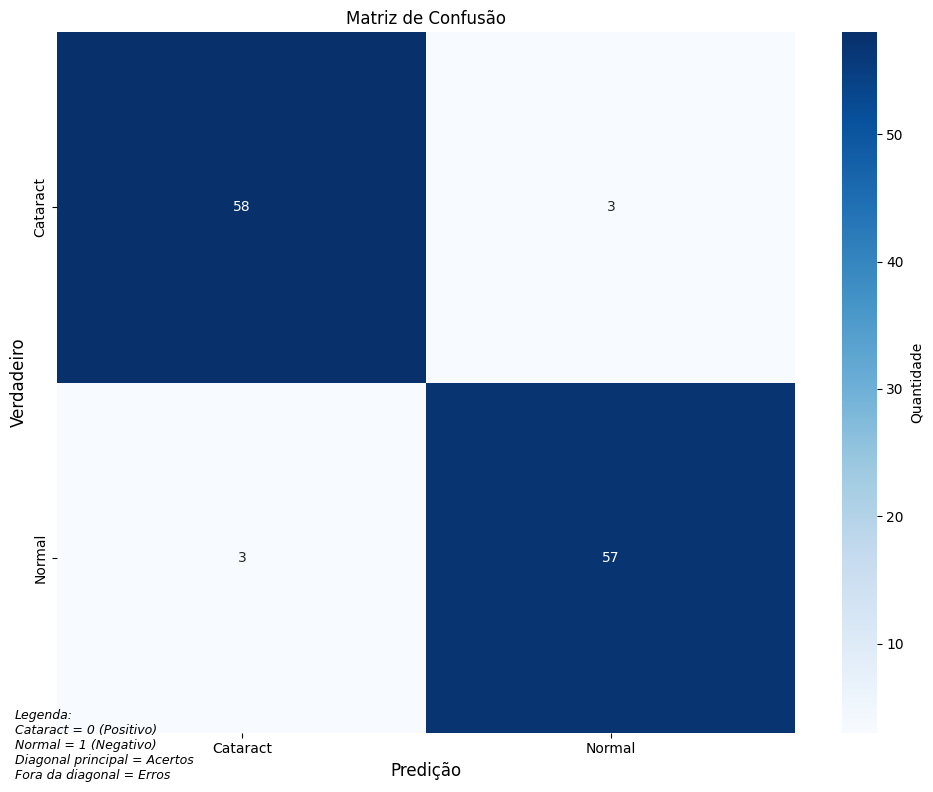

• Verdadeiros Positivos (TP): 58 - Cataratas detectadas corretamente
• Verdadeiros Negativos (TN): 57 - Normais detectados corretamente
• Falsos Positivos (FP): 3 - Normais classificados como catarata
• Falsos Negativos (FN): 3 - Cataratas perdidas (CRÍTICO!)


In [ ]:
cm = confusion_matrix(test_labels, predicted_classes) # Cria a matriz

# Plotar a matriz
plt.figure(figsize=(10,8))

sns.heatmap(
    cm,
    annot = True, # plotar os valores
    fmt = 'd', # Formato inteiro
    cmap = 'Blues',  # Mapa de cores a ser usado, no caso, azul
    xticklabels = ['Cataract', 'Normal'], # Labels X
    yticklabels = ['Cataract', 'Normal'], # Labels Y
    cbar_kws = {'label': 'Quantidade'} # legenda da barra de cores
)

plt.title("Matriz de Confusão")
plt.xlabel("Predição", fontsize = 12)
plt.ylabel("Verdadeiro", fontsize = 12)

# Adicionando texto explicativo
plt.figtext(
    0.02,
    0.02,
    'Legenda:\n'
    'Cataract = 0 (Positivo)\n'
    'Normal = 1 (Negativo)\n'
    'Diagonal principal = Acertos\n'
    'Fora da diagonal = Erros',
    fontsize = 9,
    style = 'italic'
)

plt.tight_layout()
plt.show()

tp, fn, fp, tn = cm.ravel() # desempacota a matriz de confusão nas variáveis

print(f"• Verdadeiros Positivos (TP): {tp} - Cataratas detectadas corretamente")
print(f"• Verdadeiros Negativos (TN): {tn} - Normais detectados corretamente")
print(f"• Falsos Positivos (FP): {fp} - Normais classificados como catarata")
print(f"• Falsos Negativos (FN): {fn} - Cataratas perdidas (CRÍTICO!)")

#### Métricas de avaliação gerais

In [ ]:
accuracy = accuracy_score(test_labels, predicted_classes) # Acurácia
precision = precision_score(test_labels, predicted_classes, pos_label = POSITIVE_LABEL) # Precisão
recall = recall_score(test_labels, predicted_classes, pos_label = POSITIVE_LABEL) # Recall
f1 = f1_score(test_labels, predicted_classes, pos_label = POSITIVE_LABEL) # F1 Score

print("METRICAS DE AVALIAÇÃO DO MODELO NO GERAL\n")
print(f"Recall: {recall}")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"F1 Score: {f1}")

METRICAS DE AVALIAÇÃO DO MODELO NO GERAL

Recall: 0.9508196721311475
Acurácia: 0.9504132231404959
Precisão: 0.9508196721311475
F1 Score: 0.9508196721311475


#### Métricas de avaliação por classe

In [ ]:
print("METRICAS DE AVALIAÇÃO DO MODELO NO GERAL\n")
print(classification_report(test_labels, predicted_classes))

# Adicionar a curva do treino no gráfico.

METRICAS DE AVALIAÇÃO DO MODELO NO GERAL

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        61
           1       0.95      0.95      0.95        60

    accuracy                           0.95       121
   macro avg       0.95      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121

